# 12. Revisiting the single-spore experiments

## Numerical experiments - Week 15/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Having refined the models and obtained more insight into the diffusive properties of molecules in _Aspergillus_ conidia, the inhibitor release from a single spore is simulated under several assumed diffusion and permeation constants and multiple estimated permeation constants for targeted 4-hour depletion percentages.

## Prerequisite libraries

In [1]:
using PyPlot
using CurveFit
using Statistics
using Optim
using MeshGrid
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis

## 1. Estimating the constants

### 1.1. Diffusion constants

#### 1.1.1. Known values

Several permeativities of analogue systems are known:

- the diffusion constant of glucose in water is $D=6\times10^{-6}\ \textrm{cm}^2/\textrm{s}=600\ \mu\textrm{m}^2/\textrm{s}$ [1];
- the diffusion constant of glucose in an agarose film is $D=6.38\times10^{-6}\ \textrm{cm}^2/\textrm{s}=638\ \mu\textrm{m}^2/\textrm{s}$ [2];
- the diffusion constant of glucose in cellulose nanofibrils is $D=1.7\times10^{-7}\ \textrm{cm}^2/\textrm{s}=17\ \mu\textrm{m}^2/\textrm{s}$ [3].

#### 1.1.2. Diffusion constants of 1-Octen-3-ol

The diffusion constant of 1-Octen-3-ol in water can be obtained from the Stokes-Einstein relation

$$
D=\frac{k_BT}{6\pi\eta a},
$$

considering a temperature of $T=303.15\ \textrm{K}$ (a common cultivation temperature for _Aspergillus_ conidia) and thus a thermodynamic constant of $k_BT=4.18\times10^{-21}\ \textrm{J}$.

The Stokes radius of 1-octen-3-ol can be computed from its volume, which is obtained by multiplying its molecular mass $m_M$ by its average density $\rho$. Since

$$
m_M(\textrm{1-octen-3-ol})=128.21\ \textrm{g/mol},
$$

$$
\rho(\textrm{1-octen-3-ol})=0.837\ \textrm{g/mL},
$$

the molecular volume is

$$
V_M(\textrm{1-octen-3-ol})=\frac{128.21\ \textrm{g/mol}}{0.837\ \textrm{g/mL}\cdot 6.022\times10^{23}\ \textrm{mol}^{-1}}\approx 2.54364\times 10^{-24}\ \textrm{mL},
$$

which yields a Stokes radius of

$$
a(\textrm{1-octen-3-ol}) = \left(\frac{3}{4\pi}V_M\right)^{1/3}=0.393\ \textrm{nm}.
$$

Using the viscosity of water at $303.15 \textrm{K}$,

$$
\eta(\textrm{water})=0.797 \ \textrm{mPa s},
$$

one arrives at

$$
D(\textrm{1-octen-3-ol in water})\approx 6.9016\times 10^{-6}\ \textrm{cm}^2/\textrm{s}=690.16\ \mu\textrm{m}^2/\textrm{s}.
$$



Since the Stokes radius of glucose is approximately $0.36\ \textrm{nm}$, one can obtain a comparable diffusion constant for glucose using the ratio of the Stokes radii:

$$
D(\textrm{glucose in water})=\frac{a(\textrm{1-octen-3-ol})}{a(\textrm{glucose})}\times D(\textrm{1-octen-3-ol in water})\approx 7.534\times 10^{-6}\ \textrm{cm}^2/\textrm{s}=753.4\ \mu\textrm{m}^2/\textrm{s}.
$$

This value is slightly higher than the constant found in literature, possibly due to the sensitivity of the water viscosity $\eta$ to temperature. Conversely, the ratio of the Stokes radii can be used to relate the other known diffusion constants of glucose to those of 1-octen-3-ol. Similar to glucose, the diffusivity of 1-octen-3-ol in an agarose film would be comparable to its diffusivity in water. In cellulose, the diffusion coefficient would be

$$
D(\textrm{1-octen-3-ol in cellulose})\approx \frac{a(\textrm{glucose})}{a(\textrm{1-octen-3-ol})}\times D(\textrm{glucose in cellulose})= 1.56\times 10^{-7}\ \textrm{cm}^2/\textrm{s}=15.6\ \mu\textrm{m}^2/\textrm{s}.
$$

In [31]:
# Calculation of diffusion constant
a = compute_stokes_radius(128.21, 0.822)
println("Stokes radius: ", a)
compute_D_from_radius_and_viscosity(a, 0.797)

Molecular volume: 2.590057057617608e-10
Stokes radius: 0.00039543360500816373


690.161673634019

#### 1.1.4. Diffusion constants of other VOCs

3-octanone is a structural isomer of 1-octen-3-ol and has the same molecular weight and an almost identical density of $0.822\ \textrm{g/mL}$. 3-octanol has a molecular weight of $130.23\ \textrm{g/mol}$ and a density of $0.818\ \textrm{g/mL}$, yielding a Stokes radius of approximately the same size as 1-octen-3-ol and a negligibly different diffusion constant. Hence, the diffusivity of the three VOCs can be considered equivalent.

In [32]:
# Calculation of diffusion constant
a = compute_stokes_radius(130.23, 0.818)
println("Stokes radius: ", a)
compute_D_from_radius_and_viscosity(a, 0.797)

Molecular volume: 2.643729308752991e-10
Stokes radius: 0.000398146398994561


685.4592163404097

#### 1.1.4. Diffusion constants of a heat-labile peptide

Assuming a protein with a Stokes radius of $6.0\ \textrm{nm}$, which is the upper limit of the experimentally observed molecular passages through the conidial cell wall [4], a diffusion constant through water,

$$
D(\textrm{heat-labile peptide in water})\approx 4.54855\times 10^{-7}\ \textrm{cm}^2/\textrm{s}=45.4855\ \mu\textrm{m}^2/\textrm{s},
$$

can be approximated using the Stokes-Einstein relation. Relating the size of the molecule to that of glucose, the diffusivity of the protein through cellulose could be roughly estimated:

$$
D(\textrm{heat-labile peptide in cellulose})\approx \frac{a(\textrm{glucose})}{a(\textrm{heat-labile peptide})}\times D(\textrm{glucose in cellulose})= 1.02\times 10^{-8}\ \textrm{cm}^2/\textrm{s}=1.02\ \mu\textrm{m}^2/\textrm{s}.$$

In [60]:
# Calculation of diffusion constant
a = 6.0 # nm
um2_to_cm2(compute_D_from_radius_and_viscosity(nm_to_um(a), 0.797))

4.5485519773927985e-7

### 1.2. Permeation constants

#### 1.2.1. Known values

The permeation constant of glucose in synthetic lipid bylayer found in literature is $P_s=1.4\times10^{-10}\ \textrm{cm/s}$ [5] or $P_s=2.4\times10^{-10}\ \textrm{cm/s}$ [6]. A rough average of $P_s=2.0\times10^{-10}\ \textrm{cm/s}$ is taken.

Using the Meyer-Overton rule,

$$
P_s=\frac{KD}{d},
$$

a lipid bilayer thickness $d=3.8\ \textrm{nm}$ in its liquid phase [7] and the octanol-water partition coefficient of glucose, $K=6.31\times 10^{-4}$ ($\log{K}=-3.2$) [8], the diffusion of glucose through the lipid bilayer can be quantified as

$$
D=\frac{P_sd}{K}=\frac{2.4\times10^{-10}\ \textrm{cm/s}\cdot 3.8\times 10^{-7}\ \textrm{cm}}{6.31\times 10^{-4}}\approx 1.18\times 10^{-13}\ \textrm{cm}^2/\textrm{s}=1.18\times 10^{-5}\ \mu\textrm{m}^2/\textrm{s}.
$$

In [40]:
# Calculation of diffusion constant
D = convert_Ps_to_D(cm_to_um(2e-10), 6.41e-4, nm_to_um(3.8))

1.185647425897036e-5

#### 1.2.2. Permeation constants of 1-octen-3-ol

1-octen-3-ol is less polar than glucose and its octanol-water partition coefficient is $K=316.23$ ($\log{K}=2.5$). If its diffusivity in lipid bilayers is related to the $D$ coefficient of glucose via the Stokes radii, then the Meyer-Overton rule can be used to obtain its permeation coefficient

$$
P_s(\textrm{1-octen-3-ol through lipid bilayer})=\frac{K(\textrm{1-octen-3-ol})\cdot D(\textrm{glucose in lipid bilayer})}{d}\cdot\frac{a(\textrm{glucose})}{a(\textrm{1-octen-3-ol})}\approx 9.04\times10^{-5}\ \textrm{cm/s}=0.904\ \mu\textrm{m/s}.
$$

This would describe a scenario in which the cell membrane is the rate-limiting layer of the spore envelope.

In [ ]:
# Calculation of permeation constant
convert_D_to_Ps(D, 316.23, nm_to_um(3.8)) * 0.36 / 0.393

0.0038

The Meyer-Overton rule generally does not apply in the same form to barriers different from lipid bilayers. In porous barriers, filled with water, that weakly interact with the solute, the partition coefficient can be approximated to $K\approx 1$, indicating a lack of preference for the molecule to reside inside or outside the barrier. Other factors like the porosity of the barrier can be assimilated in an effective permeation constant

$$
P_{\textrm{eff}}\approx\frac{D}{d}.
$$

It is hereby assumed that there is a rate-limiting permeability of the cell wall components, equivalent to the permeability of a specific substance, which determines the release of the inhibitor from the spore. The upper limit of the cell wall thickness in _Aspergillus_ conidia ($400\ \textrm{nm}$) [9] can be used to transform the estimated diffusion constants of 1-octen-3-ol into permeation constants:

$$
P_{\textrm{eff}}(\textrm{1-octen-3-ol through agarose})=\frac{D(\textrm{1-octen-3-ol in agarose})}{d}\approx\frac{D(\textrm{1-octen-3-ol in water})}{d}=\frac{690\ \mu\textrm{m}^2/\textrm{s}}{0.4\ \mu\textrm{m}}=0.1725\ \textrm{cm/s}=1725\ \mu\textrm{m/s},
$$

In [48]:
# Calculation of permeation constant
convert_D_to_Ps(690, 1, 0.4)

1725.0

$$
P_{\textrm{eff}}(\textrm{1-octen-3-ol through cellulose})=\frac{D(\textrm{1-octen-3-ol in cellulose})}{d}=\frac{15.6\ \mu\textrm{m}^2/\textrm{s}}{0.4\ \mu\textrm{m}}=0.0039\ \textrm{cm/s}=39\ \mu\textrm{m/s}.
$$

In [50]:
# Calculation of permeation constant
convert_D_to_Ps(15.6, 1, 0.4)

39.0

#### 1.2.3. Permeation constants of a heat-labile peptide

It is generally difficult to narrow down the range of partition coefficients for potential inhibitor proteins due to their size and complexity. Furthermore, in natural scenarios, proteins usually permeate cell membranes with the help of channels or transporters. Therefore, a permeation constant cannot be obtained in this case.

Regarding barriers of polysaccharides, the previously used approach can be applied to link the estimated diffusion constants to permeation constants:

$$
P_{\textrm{eff}}(\textrm{heat-labile peptide through agarose})=\frac{D(\textrm{heat-labile peptide in agarose})}{d}\approx\frac{D(\textrm{heat-labile peptide in water})}{d}=\frac{45.4855}{0.4\ \mu\textrm{m}}=0.011371375\ \textrm{cm/s}=113.71375\ \mu\textrm{m/s},
$$

In [62]:
# Calculation of permeation constant
convert_D_to_Ps(45.4855, 1, 0.4)

113.71375

$$
P_{\textrm{eff}}(\textrm{heat-labile peptide through cellulose})=\frac{D(\textrm{heat-labile peptide in cellulose})}{d}=\frac{1.02\ \mu\textrm{m}^2/\textrm{s}}{0.4\ \mu\textrm{m}}=2.55\times 10^{-4}\ \textrm{cm/s}=2.55\ \mu\textrm{m/s}.
$$

In [55]:
# Calculation of permeation constant
convert_D_to_Ps(1.02, 1, 0.4)

2.55

### 1.3. Summary

The following table summarises the diffusivities of different inhibitor candidates through rate-limiting barrier types:

|                                    | 1-octen-3-ol | heat-labile peptide |
|------------------------------------|--------------|---------------------|
|water                               |$D=6.9016\times 10^{-6}\ \textrm{cm}^2/\textrm{s}$|$D=4.54855\times 10^{-7}\ \textrm{cm}^2/\textrm{s}$|
|lipid bilayer membrane              |$P_s=2.0\times10^{-10}\ \textrm{cm/s}$|N/A|
|agarose-like cell wall (400 nm)     |$P_{\textrm{eff}}=0.1725\ \textrm{cm/s}$|$P_{\textrm{eff}}=0.011371375\ \textrm{cm/s}$|
|cellulose-like cell wall (400 nm)   |$P_{\textrm{eff}}=0.0039\ \textrm{cm/s}$|$P_{\textrm{eff}}=2.55\times 10^{-4}\ \textrm{cm/s}$|

## 2. Time-based concentration differences

Without knowing the precise mechanisms of inhibition, it is difficult to establish how much the concentration of the inhibitor decreases in the 4-hour period prior to the swelling phase. However, an attempt can be made to infer these from experiments with _A. nidulans_ [10], where both the effect of spore crowding and of added 1-octen-3-ol have been measured.

### 2.1. Measured relationship between crowding and germination success

The documented impact of spore density on the germination at 11 hours of incubation is as follows:

|Conidia/mL|$1\times 10^3$|$1\times 10^4$|$1\times 10^5$|$1\times 10^6$|$1\times 10^7$|$1\times 10^8$|
|----------|--------------|--------------|--------------|--------------|--------------|--------------|
|% Germination|$91.3\pm7.1$|$92.5\pm7.4$|$83\pm7.0$|$72\pm6.1$|$17\pm0.3$|$8\pm0.3$|

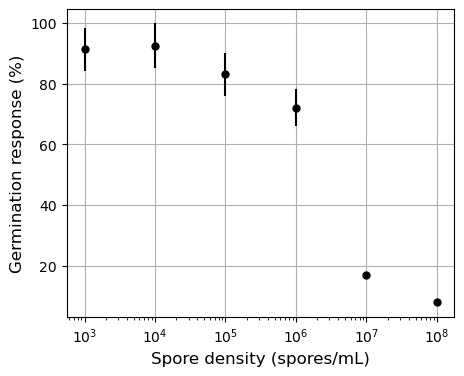

In [2]:
spore_densities = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
germination_responses_A = [91.3, 92.5, 83.0, 72.0, 17.0, 8.0]
confidence_intervals_A = [7.1, 7.4, 7.0, 6.1, 0.3, 0.3]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.errorbar(spore_densities, germination_responses_A, yerr=confidence_intervals_A, fmt="o", color="black", markersize=5, label="Germination response")
ax.set_xlabel("Spore density (spores/mL)", fontsize=12)
ax.set_ylabel("Germination response (%)", fontsize=12)
ax.set_xscale("log")
ax.grid()

gcf()

A sigmoidal tendency is observable in the data, hinting at a non-linear relationsip between the spore density and the rate of germination.

### 2.2. Measured relationship between added 1-octen-3-ol and germination success

The effect of added 1-octen-3-ol concentrations to a spore inoculum of density $10^5$ spores/mL, measured at 10 hours of incubation, is as follows:

|mM|1.0|2.5|4.0|5.0|
|----------|--------------|--------------|--------------|--------------|
|% Germination|$87\pm6.1$|$36\pm4.3$|$14\pm2.1$|$1\pm0.3$|

The control experiment yields a germination success of $95\pm5.3\%$.

Fitted parameters: 5.09074242509029 -0.01882370806130874


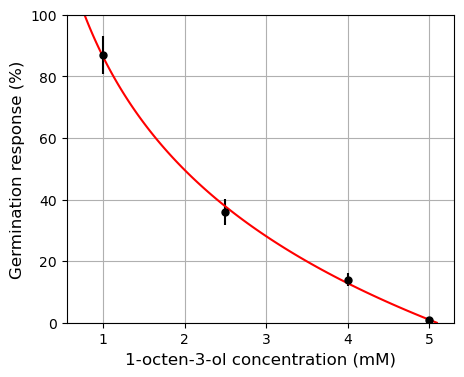

In [3]:
concentrations = [1.0, 2.5, 4.0, 5.0]
germination_responses_B = [87, 36, 14, 1]
confidence_intervals_B = [6.1, 4.3, 2.1, 0.3]

# Fit exponential model to data
fit = exp_fit(germination_responses_B, concentrations)
println("Fitted parameters: ", fit[1], " ", fit[2])

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.errorbar(concentrations, germination_responses_B, yerr=confidence_intervals_B, fmt="o", color="black", markersize=5, label="Germination response")
sample_pts = LinRange(0, 100, 100)
ax.plot(fit[1] * exp.(fit[2] .* sample_pts), sample_pts, color="red", label="Fitted curve")
ax.set_xlabel("1-octen-3-ol concentration (mM)", fontsize=12)
ax.set_ylabel("Germination response (%)", fontsize=12)
ax.grid()
ax.set_ylim(0, 100)

gcf()

Interestingly, a logarithmic function yields the closest fit through the data.

### 2.3. Equating the results via the established model

Following our hypothesis and the inhibitor saturation model derived earlier, the concentration of inhibitor in the spore follows the formula

$$
\begin{equation}
    c_{\textrm{in}}(t) = c_{\textrm{out}}(t)+\Delta{c}{(0)}e^{-\frac{t}{\tau}},
\end{equation}
$$

where $\Delta{c}{(0)}=c_0-c_{\textrm{out}}(0)$ is the concentration drop across the spore interface at time zero.

In the case of saturation driven by spore density, two approaches were previously formulated to compute the concentration accumulation just outside the spore, both producing very similar results.

**Approach 1**

Taking the simpler approach, one can write

$$
\begin{equation}
    c_{\textrm{out}}(t) = \rho_s \Delta{c}{(0)} I_{\textrm{acc}}\ e^{-\frac{t}{\tau}}.
\end{equation}
$$

where $I_{\textrm{acc}}$ is an accumulating integral over time and space. Thus,

$$
\begin{equation}
    c_{\textrm{in}}(t) = \left(1+\rho_s I_{\textrm{acc}}\right)\Delta{c}{(0)}e^{-\frac{t}{\tau}}
\end{equation}
$$

When no additional inhibitor is added at time $t=0$, $\Delta{c}{(0)}=c_0$ and the solution is

$$
\begin{equation}
    c_{\textrm{in}}(t) = \left(1 + \rho_s I_{\textrm{acc}}\right)c_0e^{-\frac{t}{\tau}}.
\end{equation}
$$

If a starting inhibitor concentration $c_{\textrm{ex}}$ is exogenously added, $\Delta{c}{(0)}=c_0-c_{\textrm{ex}}$, leading to the solution

$$
\begin{equation}
    c_{\textrm{in}}(t) = \left(1 + \rho_s I_{\textrm{acc}}\right)(c_0-c_{\textrm{ex}})e^{-\frac{t}{\tau}}.
\end{equation}
$$

**Approach 2**

In the second, more sophisticated analytical approach, the outside concentration accumulates based on two components, the inhibitor released from the measured spore ($c_{\textrm{self}}$) and the background inhibitor concentration released from the rest of the spores ($c_{\textrm{bg}}$):

$$
\begin{equation}
    c_{\textrm{out}} = c_{\textrm{self}}+c_{\textrm{bg}}.
\end{equation}
$$

$c_{\textrm{bg}}$ dynamically increases as the spores release more inhibitor, driving $c_{\textrm{out}}$ up and counteracting the exponential decay. It is a density-dependent term of the form

$$
\begin{equation}
c_{\textrm{bg}}=\rho_s \Delta{c}{(0)} I_{\textrm{bg}}\ e^{-\frac{t}{\tau}},
\end{equation}
$$

$c_{\textrm{self}}$ also increases as more inhibitor is released from the spore, but it incorporates only a density-independent integral over time:

$$
\begin{equation}
c_{\textrm{self}}=\Delta{c}{(0)}I_{\textrm{self}}\ e^{-\frac{t}{\tau}}.
\end{equation}
$$

Thus,

$$
\begin{equation}
    c_{\textrm{in}}(t) = \left(1 + I_{\textrm{self}} + \rho_s I_{\textrm{bg}}\right)\Delta{c}{(0)}e^{-\frac{t}{\tau}}
\end{equation}
$$

When no additional inhibitor is added at time $t=0$, $\Delta{c}{(0)}=c_0$ and the solution is

$$
\begin{equation}
    c_{\textrm{in}}(t) = \left(1 + I_{\textrm{self}} + \rho_s I_{\textrm{bg}}\right)c_0e^{-\frac{t}{\tau}}.
\end{equation}
$$

If a starting inhibitor concentration $c_{\textrm{ex}}$ is exogenously added, $\Delta{c}{(0)}=c_0-c_{\textrm{ex}}$, leading to the solution

$$
\begin{equation}
    c_{\textrm{in}}(t) = \left(1 + I_{\textrm{self}} + \rho_s I_{\textrm{bg}}\right)(c_0-c_{\textrm{ex}})e^{-\frac{t}{\tau}}.
\end{equation}
$$

**Correlating the empirical results**

Assuming that the two germination experiments contain spores with the same distribution of heterogeneity, an equivalent average concentration drop would lead to an equivalent germination percentage. It is easy to fit an exponential relationship through the data points for germination percentage and inhibitor concentration in the second model. Evaluating this function at the germination percentages from the first experiment, one can obtain the exogenous 1-octen-3-ol concentration equivalents of the different spore densities.

For simplicity, it is assumed that both results are valid for 10 hours of incubation, even though the first measurements were taken at the 11-hour mark. At a first glance, the germination rate of $95\pm5.3\%$ for control experiment at $10^5$ spores/mL and zero added inhibitor has a minor confidence interval overlap with the $83\pm7.0\%$ germination success of the $10^5$ spores/mL setup in the variable spore density experiments. Since further data on the samples is lacking, this can be taken as sufficient evidence that the results follow the same distribution.

In [4]:
ex_conc_equivalents = fit[1] * exp.(fit[2] .* germination_responses_A)

for i in 1:length(germination_responses_A)
    println("Spore density: ", spore_densities[i], " Germination response: ", germination_responses_A[i], " Exogenous concentration equivalent: ", ex_conc_equivalents[i])
end

Spore density: 1000.0 Germination response: 91.3 Exogenous concentration equivalent: 0.912852591491095
Spore density: 10000.0 Germination response: 92.5 Exogenous concentration equivalent: 0.8924638090818455
Spore density: 100000.0 Germination response: 83.0 Exogenous concentration equivalent: 1.0672186913225532
Spore density: 1.0e6 Germination response: 72.0 Exogenous concentration equivalent: 1.3127401879158425
Spore density: 1.0e7 Germination response: 17.0 Exogenous concentration equivalent: 3.6966264831416455
Spore density: 1.0e8 Germination response: 8.0 Exogenous concentration equivalent: 4.379059673750989


Equating the concentration formulas for the two experiments (using Approach 1),

$$
\begin{equation}
\left(1 + \rho_s I_{\textrm{acc}}\right)c_0 = \left(1 + \rho_s' I_{\textrm{acc}}\right)(c_0-c_{\textrm{ex}}).
\end{equation}
$$

Here, $\rho_s'$ denotes the reference density of $10^5$ spores/mL and $\rho_s$ is the variable density linked to the exogenous inhibitor equivalent. Solving this for the initial concentration $c_0$ yields

$$
\begin{equation}
c_0=\frac{c_{\textrm{ex}}(1+\rho_s'I_{\textrm{acc}})}{I_{\textrm{acc}}(\rho_s'-\rho_s)}.
\end{equation}
$$

Alternatively, if the second approach is used, the relationship becomes

$$
\begin{equation}
c_0=\frac{c_{\textrm{ex}}(1+I_{\textrm{self}}+\rho_s'I_{\textrm{bg}})}{I_{\textrm{bg}}(\rho_s'-\rho_s)}.
\end{equation}
$$

The term in the denominator can assume negative values for densities smaller than the reference spore density. This makes sense, because according to the mathematical approach, $\rho_s'=10^5$ corresponds to the "ground-zero" from which additions in exogenous concentrations correspond to additions of spores. Conversely, if spores are taken away from the reference point, the corresponding exogenous concentration would be negative, i.e. inhibitor molecules need to be removed from the system.

The integrals in the expression need to be evaluated numerically to obtain a value for $c_0$. According to the analytical derivations,

$$
\begin{equation}
I_{\textrm{acc}}=\frac{AP_s}{4\pi D^{3/2}}\int_0^{R_{\textrm{diff}}}{d{r}\ r^2\int_0^t{t'^{-3/2}e^{\left(\frac{t'}{\tau}-\frac{r^2}{4Dt'}\right)}dt'}},
\end{equation}
$$

$$
\begin{equation}
I_{\textrm{self}}=RP_s\int_0^t{e^{\frac{t-t'}{\tau}}\frac{1}{\sqrt{4\pi D(t-t')}}\left[1-\frac{P_s}{D}e^{\frac{P_s^2(t-t')}{D^2}}\textrm{erfc}{\left(\frac{P_s\sqrt{t-t'}}{D}\right)}\right]\ d{t'}},
\end{equation}
$$

$$
\begin{equation}
I_{\textrm{bg}}=\frac{AP_s}{4\pi D^{3/2}}\int_R^{R_{\textrm{diff}}}{d{r}\ r^2\int_0^t{t'^{-3/2}e^{\left(\frac{t'}{\tau}-\frac{r^2}{4Dt'}\right)}dt'}}.
\end{equation}
$$

In [118]:
using QuadGK
using SpecialFunctions

function I_acc(t, Rdiff; A, Ps, D, τ)
    coeff = A * Ps / (4π * D^(3/2))
    inner_integral(r) = quadgk(tprime -> tprime^(-3/2) * exp(tprime/τ - r^2/(4*D*tprime)), 0, t, rtol=1e-6)[1]
    outer_integral = quadgk(r -> r^2 * inner_integral(r), 0, Rdiff, rtol=1e-6)[1]
    return coeff * outer_integral
end

function I_self(t; R, Ps, D, τ)
    integrand(tprime) = exp((t - tprime)/τ) / sqrt(4π * D * (t - tprime)) *
        (1 - (Ps / D) * exp(Ps^2 * (t - tprime) / D^2) * erfc(Ps * sqrt(t - tprime) / D))
    # Integrate from 0 to t; note that t - tprime is always ≥ 0 if tprime ∈ [0, t]
    I = quadgk(integrand, 0, t, rtol=1e-6)[1]
    return R * Ps * I
end

function I_bg(t, R, Rdiff; A, Ps, D, τ)
    coeff = A * Ps / (4π * D^(3/2))
    inner_integral(r) = quadgk(tprime -> tprime^(-3/2) * exp(tprime/τ - r^2/(4*D*tprime)), 0, t, rtol=1e-6)[1]
    outer_integral = quadgk(r -> r^2 * inner_integral(r), R, Rdiff, rtol=1e-6)[1]
    return coeff * outer_integral
end

# Example usage:
spore_diameter = 5.0
R = spore_diameter * 0.5                                           # Sphere radius
A, V = compute_spore_area_and_volume_from_dia(spore_diameter)       # Surface area and volume of the sphere
D = 600                                                             # Diffusion coefficient
Ps = 0.0002675353069511818                                          # Permeation constant
τ = V / (A * Ps)                                                    # Decay time constant
t = 36000                                                           # Total integration time (10 hours)
Rdiff = sqrt(4 * D * t)                                             # Effective diffusion radius scale

Iacc = I_acc(t, Rdiff; A=A, Ps=Ps, D=D, τ=τ)
Iself = I_self(t; R=R, Ps=Ps, D=D, τ=τ)
Ibg   = I_bg(t, R, Rdiff; A=A, Ps=Ps, D=D, τ=τ)

println("I_acc = ", Iacc)
println("I_self = ", Iself)
println("I_bg = ", Ibg)

# Get exogenous concentration equivalents for different spore densities above 10^5 and compute c0
ρ_ref = 1e5
for (i, ρ) in enumerate(spore_densities[spore_densities .≥ ρ_ref])
    c_ex = ex_conc_equivalents[i]
    c0_A = c_ex * (1 + ρ_ref*Iacc) / (Iacc * (ρ_ref - ρ))
    c0_B = c_ex * (1 + Iself + ρ_ref*Ibg) / (Ibg * (ρ_ref - ρ))
    println("Spore density: ", ρ, " Germination response: ", germination_responses_A[i], " Exogenous concentration equivalent: ", ex_conc_equivalents[i], " c0_A: ", c0_A, " c0_B: ", c0_B)
end

I_acc = 905272.5880528602
I_self = 13.893331570792796
I_bg = 905272.5879953303
Spore density: 100000.0 Germination response: 91.3 Exogenous concentration equivalent: 0.912852591491095 c0_A: Inf c0_B: Inf
Spore density: 1.0e6 Germination response: 92.5 Exogenous concentration equivalent: 0.8924638090818455 c0_A: -0.0991626454546338 c0_B: -0.09916264546985239
Spore density: 1.0e7 Germination response: 83.0 Exogenous concentration equivalent: 1.0672186913225532 c0_A: -0.01077998678115497 c0_B: -0.010779986782809389
Spore density: 1.0e8 Germination response: 72.0 Exogenous concentration equivalent: 1.3127401879158425 c0_A: -0.0013140542421725162 c0_B: -0.0013140542423741854


It is clear that by using arbitrary diffusion and permeation constants, the resulting $c_0$ values are inconsistent. Therefore, a minimisation procedure needs to be implemented, which takes variable $D$ and $P_s$ and fits their values with respect to minimising the standard deviation of $c_0$ under variable $c_{\textrm{ex}}$ inputs. The standard deviation is thereby normalised by dividing by the mean $\langle c_0\rangle_{c_{\textrm{ex}}}$.

Minimum coefficient of variation 1.183878729458531 for P_s=1.555676143930472e-11: <c_0>=0.005369144975340662
[0.012524744904883681, 0.0032062914266997346, 0.00037639859443856685]


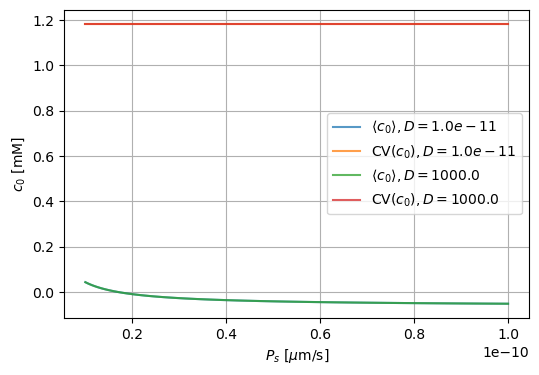

In [119]:
# matplotlib.pyplot.close()

function calc_c0(D, Ps, spore_diameter, ρ_ref, t)
    
    R = spore_diameter * 0.5                                            # Sphere radius
    A, V = compute_spore_area_and_volume_from_dia(spore_diameter)       # Surface area and volume of the sphere
    τ = V / (A * Ps)                                                    # Decay time constant
    Rdiff = sqrt(4 * D * t)                                             # Effective diffusion radius scale
    
    Iacc = I_acc(t, Rdiff; A=A, Ps=Ps, D=D, τ=τ)
    # Iself = I_self(t; R=R, Ps=Ps, D=D, τ=τ)
    # Ibg   = I_bg(t, R, Rdiff; A=A, Ps=Ps, D=D, τ=τ)

    c0 = ex_conc_equivalents[spore_densities .> ρ_ref] .* (1 - ρ_ref*Iacc) ./ (Iacc .* (spore_densities[spore_densities .> ρ_ref] .- ρ_ref))
    # c0 = ex_conc_equivalents[spore_densities .> ρ_ref] .* (1 - Iself - ρ_ref*Ibg) ./ (Ibg .* (spore_densities[spore_densities .> ρ_ref] .- ρ_ref))
    # c0 = ex_conc_equivalents[spore_densities .> ρ_ref] .* (1 - ρ_ref*Ibg) ./ (Ibg .* (spore_densities[spore_densities .> ρ_ref] .- ρ_ref))

    return c0
end

# Find means and coefficients of variation of c0 for different D and Ps values
# D_vals = LinRange(1e-11, 1000, 100)
# Ps_vals = LinRange(1e-11, 1e-10, 100)#00)
D_vals = 10 .^ LinRange(-11, 3, 100)
Ps_vals = 10 .^ LinRange(-11, -10, 100)#00)

c0_means = zeros(length(D_vals), length(Ps_vals))
c0_norm_vars = zeros(length(D_vals), length(Ps_vals))
for i in 1:length(D_vals)
    for j in 1:length(Ps_vals)
        c0 = calc_c0(D_vals[i], Ps_vals[j], spore_diameter, ρ_ref, t)
        c0_means[i, j] = mean(c0)
        c0_norm_vars[i, j] = std(c0) / abs(c0_means[i, j])
    end
end
# query_idx = 1
# min_idx = argmin(c0_vars[query_idx, :])
# println("Minimum variance ", c0_vars[query_idx, min_idx]," for P_s=$(Ps_vals[min_idx]): <c_0>=$(c0_means[query_idx, min_idx])")
min_idx = argmin(c0_norm_vars)
println("Minimum coefficient of variation ", c0_norm_vars[min_idx]," for P_s=$(Ps_vals[min_idx[2]]): <c_0>=$(c0_means[min_idx])")
println(calc_c0(D_vals[min_idx[1]], Ps_vals[min_idx[2]], spore_diameter, ρ_ref, t))

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(Ps_vals, c0_means[1, :], label=L"\langle c_0\rangle, D=%$(D_vals[1])", alpha=0.75)
ax.plot(Ps_vals, c0_norm_vars[1, :], label=L"\text{CV}{(c_0)}, D=%$(D_vals[1])", alpha=0.75)
ax.plot(Ps_vals, c0_means[end, :], label=L"\langle c_0\rangle, D=%$(D_vals[end])", alpha=0.75)
ax.plot(Ps_vals, c0_norm_vars[end, :], label=L"\text{CV}{(c_0)}, D=%$(D_vals[end])", alpha=0.75)
# ax.axvline(Ps_vals[min_idx[2]], color="red", linestyle="--", label="Minimum variance")
ax.set_xlabel(L"P_s\ [\mu\text{m/s}]")
ax.set_ylabel(L"c_0\ [\text{mM}]")
ax.grid()
ax.legend()

gcf()

The solutions for $c_0$ seem mostly insensitive to changes in $D$. A narrow range in $P_s$ enables physically meaningful values for the initial concentration, but even then the three input quantities of $c_{\textrm{ex}}$ produce $c_0$ outputs with a consistent coefficient of variability, indicating the failure of the model to explain and link the experimental data in a coherent way.

The problem could also be formulated in an inverse way - fix $c_0$ and vary $\rho$ to observe the changes in $c_{\textrm{ex}}$, expressed as

$$
\begin{equation}
c_{\textrm{ex}}=\frac{c_0I_{\textrm{acc}}(\rho_s'-\rho_s)}{1+\rho_s'I_{\textrm{acc}}}.
\end{equation}
$$

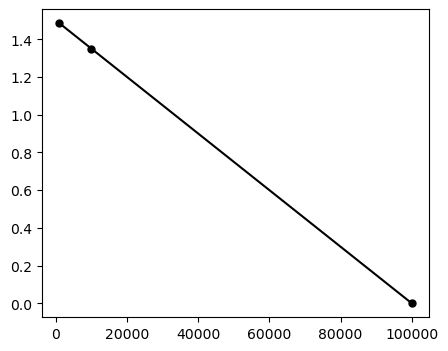

In [126]:
c0 = 1.5

c_ex_results = zeros(length(spore_densities))
for i in 1:length(spore_densities)
    c_ex = c0 * (Iacc * (ρ_ref - spore_densities[i]) / (1 + ρ_ref*Iacc))
    c_ex_results[i] = c_ex
end

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(spore_densities[1:3], c_ex_results[1:3], "-o", color="black", markersize=5, label="Exogenous concentration equivalent")
gcf()

Several conclusions can be drawn from this attempt:
- no statements about the initial inhibitor concentrations at the spores could be derived in this manner;
- the suppresion of germination due to crowding likely does not follow the simple logic of 1-octen-3-ol inhibitor saturation;
- more complex interactions may be at play, as indicated by the sigmoidal relationship between spore density and germination rate as well as the logarithmic relationship between added concentration and germination rate.

### 2.4. Heuristics for finding $c_0$

Another approach that can be used to estimate the upper limit of the inhibitor concentration is by referring to the measured concentration of 1-octen-3-ol released by conidia. Studies with _A. flavus_ have shown that, even after repetitive freeze-dry treatment to destroy the integrity of the conidial envelope, the released concentration of 1-octen-3-ol in the medium was below $1\ \mu\textrm{M}$ [11]. The experiment was performed at a conidial density of $10^9$ spores/mL in a $300\ \mu\textrm{L}$ suspension, which is equivalent to $3\times 10^8$ spores. The quantity of 1-octen-3-ol in the volume of the suspension can be calculated to $3\times 10^{-10}$ moles. Distributing these molecules over the spherical volumes of the conidia, equal to $\frac{4}{3}\pi R^3=6.54\times 10^{-14}\ \textrm{L}$ each, results in a maximum concentration of $1.5\times 10^{-5}\ \textrm{M}$ per conidium.

As for the concentration of the second inhibitor candidate, the heat-labile peptide, a precise estimate is difficult to pinpoint, but a moderate abundance would likely be in the micromolar order. Therefore, a reference value of $c_0=10^{-6}\ \textrm{M}$ can be taken.

### 2.5. Threshold for inhibition

The threshold for inhibition is another variable that can be narrowed down using experimental observations. Resorting to the _A. nidulans_ studies [10], it is evident that an exogenously added $1\ \textrm{mM}$ of 1-octen-3-ol already causes inhibition. In studies with _A. flavus_, not less than $10\ \textrm{mM}$ added 1-octen-3-ol was needed to induce inhibition [11]. Both of these values are much higher than the supposed initial concentration at the spore. This is logical, if one considers that a significant $c_{\textrm{out}}$ concentration is needed to delay the endogenous release of inhibitor from the spore.

Despite the flaws of the model in reconstructing a coherent initial concentration, an attempt can be made to use it for finding the concentration threshold $c_T$ given the empirical germination data. Given the heterogeneity of the spores and the fact that there is no hard threshold beyond which all of them stop germinating, the first question is how to define $c_T$ based on germination statistics.

![Inhibitor thresholds](Data/inhibitor_thresholds.png)

<!-- It can be assumed that each spore has a slightly varying release rate, leading to a concentration $c{(t_{\textrm{max}})}=C$ at the time of measurement $t_{\textrm{max}}$, where $C$ is a random variable. Concurrently, each spore has its inherent, sligthly varying concentration threshold for germination $T$, which is also a random variable, albeit not necessarily correlated with or from the same distribution as $C$.

Thus, a spore germinates if $C<T$. In the case when all spores germinate, it is guaranteed that the highest $C$ is lower than the lowest $T$. If the environmental conditions change in a way that the release is affected, it can be assumed that the distribution $C$ shifts upward in a consistent manner. Then, the germination fraction can be expressed as

$$
\begin{equation}
p=P(C<T).
\end{equation}
$$

In order to capture $C$ into a single final concentration variable $c_F$, we need to define $c_F$ such that, if all spores had the same effective final concentration, their germination fraction would be the same under the changed environmental conditions:

$$
\begin{equation}
p=P(c_F<T).
\end{equation}
$$

Let $F_T$ denote the cumulative distribution function of the thresholds (the probability that the threshold is less than or equal to a given value). Then,

$$
\begin{equation}
p=P(T>c_F)=1-F_T(c_F).
\end{equation}
$$

Solving for $c_F$, one obtains the expression

$$
\begin{equation}
c_F=F_T^{-1}(1-p).
\end{equation}
$$

For simplicity, one can assume that the shift in $c{(t_{\textrm{max}})}$ under changing the germination conditions is a constant for all spores, denoted as $\Delta$. Thus, the transformed final concentrations become

$$
\begin{equation}
c{(t_{\textrm{max}})}=C+\Delta.
\end{equation}
$$

Consequently, the effective final concentrations also change by the same amount:

$$
\begin{equation}
c_F^{\textrm{shifted}}=c_F+\Delta.
\end{equation}
$$

Rearranging this, one can express the shift as

$$
\begin{equation}
\Delta=c_F^{\textrm{shifted}}-c_F=F_T^{-1}(1-p_2)-F_T^{-1}(1-p_1),
\end{equation}
$$

where $p_1$ is the fraction of germinated spores before the shift and $p_2$ is the updated fraction of germinated spores.

Starting with the simpler analytical scheme,

$$
\begin{equation}
c_T=\left(I_{\textrm{self}} + \rho_s I_{\textrm{bg}} - 1\right)\Delta{c}{(0)}e^{-\frac{t}{\tau}}
\end{equation}
$$ -->

Whichever analytical model we choose (with or without external concentration accumulation), the general formula for the concentration at the measurement time $t_\textrm{max}$ can be expressed as:

$$
\begin{equation}
c_{\textrm{in}}{(t_\textrm{max})}=A(c_0-c_{\textrm{ex}})e^{-\frac{t}{\tau}}.
\end{equation}
$$

We approximate $A$ by a constant over all spores, since it was shown that the accumulation integrals have a negligible effect compared to the exponential relaxation at moderate spore densities. The characteristic relaxation time, however, depends on the surface-to-volume ratio of the spore and may exhibit variability within the inoclulum, therefore it is modelled by a random variable. Thus, denoting the final measured concentration as $c_F$,

$$
\begin{equation}
c_F{(\tau, c_{\textrm{ex}})}=A(c_0-c_{\textrm{ex}})e^{-\frac{t_{\textrm{max}}}{\tau}}.
\end{equation}
$$

The condition for germination is that the final concentration is below the germination threshold $c_T$, which is also a random variable:

$$
\begin{equation}
c_F{(\tau, c_{\textrm{ex}})}\le c_T.
\end{equation}
$$

Conditional on $\tau$, the probability that a spore germinates is

$$
\begin{equation}
P(\textrm{germination}\ | \ \tau)=P(c_T\ge c_F{(\tau, c_{\textrm{ex}})})=1-P(c_F{(\tau, c_{\textrm{ex}})}>c_T)=1-F_\Theta(c_F{(\tau, c_{\textrm{ex}})}),
\end{equation}
$$

where $F_\Theta(x)$ is the cumulative distribution function (CDF) of the germination thresholds. Averaging over the distribution of $\tau$, one can find the fraction $G$ of spores that germinate under a given $c_{\textrm{ex}}$:

$$
\begin{equation}
G(c_{\textrm{ex}})=\int{p{(\tau)}\left[1-F_\Theta\left(A(c_0-c_{\textrm{ex}})e^{-\frac{t}{\tau}}\right)\right]d{\tau}},
\end{equation}
$$

where $p{(\tau)}$ is the probability density of $\tau$. For the sake of simplicity, it can be assumed that the characteristic $\tau$ does not vary significantly, compared to the germination thresholds - it mostly depends on the spherical area-to-volume ratio, which only sligthly changes among spores, while the threshold may be related to more complex physiological characteristics. In this case, the above fraction can be approximated using an average $\bar{\tau}$:

$$
\begin{equation}
G(c_{\textrm{ex}})\approx 1-F_\Theta\left(A(c_0-c_{\textrm{ex}})e^{-\frac{t}{\bar{\tau}}}\right).
\end{equation}
$$

Assuming that the distribution of threshold concentrations is symetric, its mean would coincide with its median. Thus, one can identify a reference point in the exogenous concentration addition when the germination response is 50%:

$$
\begin{equation}
G(c_{\textrm{ex}^{50\%}})=0.5,
\end{equation}
$$

and substitute the germination fraction in the general formula:

$$
\begin{equation}
0.5= 1-F_\Theta\left(A(c_0-c_{\textrm{ex}}^{50\%})e^{-\frac{t}{\bar{\tau}}}\right),
\end{equation}
$$

$$
\begin{equation}
F_\Theta\left(A(c_0-c_{\textrm{ex}}^{50\%})e^{-\frac{t}{\bar{\tau}}}\right)=0.5.
\end{equation}
$$

This means that the mean of the thresholds can be expressed as

$$
\bar{c_T}=A(c_0-c_{\textrm{ex}}^{50\%})e^{-\frac{t}{\bar{\tau}}}.
$$

Assuming $A=1$ for the simplest case, the threshold for 1-octen-3-ol is computed below for all candidate permeabilities at time $t_{\textrm{max}}=10\ \textrm{h}$.

In [33]:
c0 = 1.5 # 1e-5 M
t_max = 36000 # 10 hours
A, V = compute_spore_area_and_volume_from_dia(5.0)
Ps_variants = [2e-10, 0.1725, 0.0039] # [cm/s]
Ps_variants = [cm_to_um(Ps) for Ps in Ps_variants]

D = 600
B = 1.0

c_ex_median = fit[1] * exp.(fit[2] .* 50)
println("c_ex_median: ", c_ex_median)

for Ps in Ps_variants

    # Constants
    τ = V / (A * Ps) # Decay time constant
    
    c_thresh = B * (c_ex_median - c0) * exp(-t_max / τ) 
    println("P_s: ", Ps, " c_thresh: ", c_thresh)
end

c_ex_median: 1.9862298149123427
P_s: 2.0e-6 c_thresh: 0.44598324422969843
P_s: 1724.9999999999998 c_thresh: 0.0
P_s: 39.0 c_thresh: 0.0


The only threshold of significant value is the one for the slowest permeability, the other ones are too close to zero to be represented within machine precision. In fact, alternative calculations show that the faster releasing systems yield thresholds much smaller than the physically possible concentrations of molecules inside a cell.

This study leads to the following conclusions:
- the germination thresholds are strongly dependent on the assumed rate of permeation.

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

A simple assumption for the lower bound of the inhibition threshold $c_T$ would be that the inhibitor stops working once there are only about a hundred molecules left in the spore. Referring this amount to the volume of a spore with a diameter of $5\ \mu\textrm{m}$, one arrives at a concentration of approximately $2.54\times 10^{-9}\ \textrm{M}$.

## 3. Comparing the different inhibitor release scenarios

Using the diffusion coefficient assumptions, the time-dependent inhibitor release is computed for multiple inhibitor-barrier scenarios, using the simple permeation scheme. Parallel to that, different thresholds of inhibition at $t=4\ \textrm{h}$, from $10^{-1}$ to $10^{-10}\ \textrm{M}$, are tested to find the corresponding permeation constants leading to their attainment.

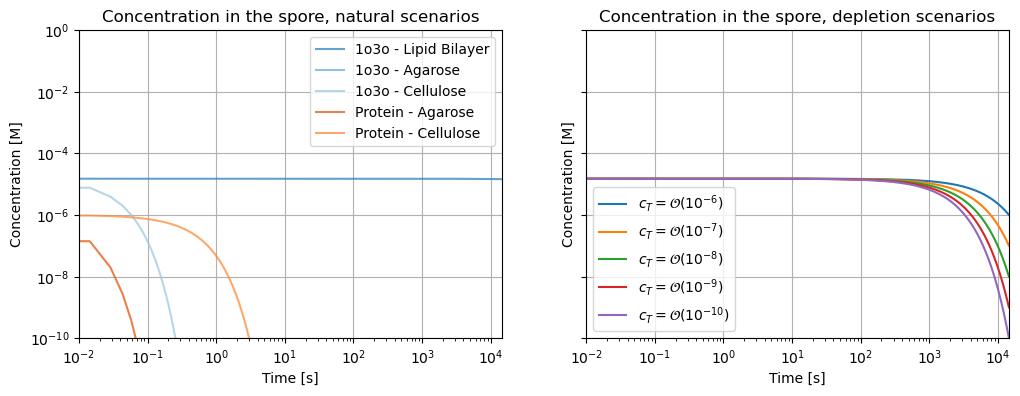

In [117]:
spore_diameter = 5.0 # um
A, V = compute_spore_area_and_volume_from_dia(spore_diameter)

t_max = 14400 # 4 hours
n_frames = 1000000
times = collect(LinRange(0, t_max, n_frames))

# 1-octen-3-ol
c0_oct = 1.5 # 1e-5 M
D = cm2_to_um2(6.906e-6) # [um^2/s]
Ps_variants = [2e-10, 0.1725, 0.0039] # [cm/s]
Ps_variants = cm_to_um.(Ps_variants)
labels_oct = ["1o3o - Lipid Bilayer", "1o3o - Agarose", "1o3o - Cellulose"]

c_vals_oct = []
for (i, Ps) in enumerate(Ps_variants)
    push!(c_vals_oct, permeation_time_dependent_analytical(c0_oct, 0, times, Ps, A, V) .* 1e-5)
end

# Heat-labile peptide
c0_prot = 0.1 # 1e-5 M
D = cm2_to_um2(4.54855e-7) # [um^2/s]
Ps_variants = [0.01137, 2.55e-4] # [cm/s]
Ps_variants = cm_to_um.(Ps_variants)
labels_prot = ["Protein - Agarose", "Protein - Cellulose"]

c_vals_prot = []
for (i, Ps) in enumerate(Ps_variants)
    push!(c_vals_prot, permeation_time_dependent_analytical(c0_prot, 0, times, Ps, A, V) .* 1e-5)
end

# Fit permeation constants
exponents = LinRange(-1, -5, 5)
cT_range = 10 .^ exponents
labels_fit = [L"c_T = \mathcal{O}{(10^{%$(round(Int, e - 5))}})" for e in exponents]
Ps_fits = compute_permeation_constant.(cT_range, 0.0, c0_oct, t_max, A, V)

# Simulate fitted Ps
c_vals_fit = []
times_fit = []
for (i, Ps) in enumerate(Ps_fits)
    push!(c_vals_fit, permeation_time_dependent_analytical(c0_oct, 0, times, Ps, A, V) .* 1e-5)
    push!(times_fit, times)
end

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=true)
compare_concentration_evolution_groups([c_vals_oct, c_vals_prot], [[times, times, times], [times, times]], [labels_oct, labels_prot], ax[1], logx=true, logy=true, title="Concentration in the spore, natural scenarios")
compare_concentration_evolutions(c_vals_fit, times_fit, labels_fit, ax[2], logx=true, logy=true, title="Concentration in the spore, depletion scenarios")
gcf()

The results confirm that, under the assumed initial concentrations, the permeation of 1-octen-3-ol and of the hypothetical protein through an agarose- or cellulose-like barrier occurs too fast to meet any realistic threshold at a time mark longer than 10 seconds.

The permeation of 1-octen-3-ol through a lipid bilayer, on the other hand, proceeds too slowly to cause any significant reduction within 4 hours of incubation.

## References

- [1] Höber, R. Physikalische Chemie der Zelle und der Gewebe. Nature, 112, 93-93.
- [2] Zhang, T., & Fang, H. (2005). Effective Diffusion Coefficients of Glucose in Artificial Biofilms. Environmental Technology, 26, 155 - 160.
- [3] Carter, N., Towne, J., & Neivandt, D.J. (2021). Finite element analysis of glucose diffusivity in cellulose nanofibril peripheral nerve conduits. Cellulose, 28, 2791 - 2803.
- [4] Brul, S., Nussbaum, J., & Dielbandhoesing, S.K. (1997). Fluorescent probes for wall porosity and membrane integrity in filamentous fungi. Journal of Microbiological Methods, 28, 169-178.
- [5] Bresseleers, G.J., Goderis, H.L., & Tobback, P. (1984). Measurement of the glucose permeation rate across phospholipid bilayers using small unilamellar vesicles. Effect of membrane composition and temperature. Biochimica et biophysica acta, 772 3, 374-82 .
- [6] Jakubowski, H.V., Flatt, P., Agnew, H., & Larsen, D. (2022). Fundamentals of Biochemistry, a free and new LibreText book for Undergraduate Courses. The FASEB Journal, 36.
- [7] Yarrow, F., & Kuipers, B.W. (2011). AFM study of the thermotropic behaviour of supported DPPC bilayers with and without the model peptide WALP23. Chemistry and physics of lipids, 164 1, 9-15.
- [8] Mazzobre, M.F., Román, M., Mourelle, A.F., & Corti, H.R. (2005). Octanol-water partition coefficient of glucose, sucrose, and trehalose. Carbohydrate research, 340 6, 1207-11.
- [9] Beauvais, A., Bozza, S., Kniemeyer, O., Formosa, C., Balloy, V., Henry, C., Roberson, R.W., Dague, E., Chignard, M., Brakhage, A.A., Romani, L., & Latgé, J.P. (2013). Deletion of the α-(1,3)-Glucan Synthase Genes Induces a Restructuring of the Conidial Cell Wall Responsible for the Avirulence of Aspergillus fumigatus. PLoS Pathogens, 9.
- [10] Herrero-García, E., Garzia, A., Cordobés, S., Espeso, E.A., & Ugalde, U. (2011). 8-Carbon oxylipins inhibit germination and growth, and stimulate aerial conidiation in Aspergillus nidulans. Fungal biology, 115 4-5, 393-400.
- [11] Miyamoto, K., Murakami, T., Kakumyan, P., Keller, N.P., & Matsui, K. (2014). Formation of 1-octen-3-ol from Aspergillus flavus conidia is accelerated after disruption of cells independently of Ppo oxygenases, and is not a main cause of inhibition of germination. PeerJ, 2.